In [1]:
import os
base_path="C:/Users/Dharmarajan/Documents/Guvi/Project/Final Project/Emotion Detection/Data/"
train_path=os.path.join(base_path,"train")
test_path=os.path.join(base_path,"test")

In [2]:
train_total=0
for d in os.listdir(train_path):
    path = os.path.join(train_path, d)
    img_count = len(os.listdir(path))
    train_total += img_count
    print(f'{d:50} : {img_count}')

print(f'\nTotal training images: {train_total}')

angry                                              : 3995
disgust                                            : 436
fear                                               : 4097
happy                                              : 7215
neutral                                            : 4965
sad                                                : 4830
surprise                                           : 3171

Total training images: 28709


In [3]:
test_total=0
for d in os.listdir(test_path):
    path = os.path.join(test_path, d)
    img_count = len(os.listdir(path))
    test_total += img_count
    print(f'{d:50} : {img_count}')

print(f'\nTotal Test images: {test_total}')

angry                                              : 958
disgust                                            : 111
fear                                               : 1024
happy                                              : 1774
neutral                                            : 1233
sad                                                : 1247
surprise                                           : 831

Total Test images: 7178


In [4]:
total_classes = len(os.listdir(train_path))

print(f'\nTotal number of classes: {total_classes}')


Total number of classes: 7


In [5]:
import pandas as pd
train_data = []

for index, cls_name in enumerate(os.listdir(train_path)):
    folder_path = os.path.join(train_path, cls_name)
    if os.path.isdir(folder_path):
        for root, _, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                train_data.append((index, cls_name, file_path))

# Convert the list to a DataFrame
train_df = pd.DataFrame(train_data, columns=['Class Id', 'Class Name', 'File_Path'])

# Print the resulting DataFrame
print(train_df)

       Class Id Class Name                                          File_Path
0             0      angry  C:/Users/Dharmarajan/Documents/Guvi/Project/Fi...
1             0      angry  C:/Users/Dharmarajan/Documents/Guvi/Project/Fi...
2             0      angry  C:/Users/Dharmarajan/Documents/Guvi/Project/Fi...
3             0      angry  C:/Users/Dharmarajan/Documents/Guvi/Project/Fi...
4             0      angry  C:/Users/Dharmarajan/Documents/Guvi/Project/Fi...
...         ...        ...                                                ...
28704         6   surprise  C:/Users/Dharmarajan/Documents/Guvi/Project/Fi...
28705         6   surprise  C:/Users/Dharmarajan/Documents/Guvi/Project/Fi...
28706         6   surprise  C:/Users/Dharmarajan/Documents/Guvi/Project/Fi...
28707         6   surprise  C:/Users/Dharmarajan/Documents/Guvi/Project/Fi...
28708         6   surprise  C:/Users/Dharmarajan/Documents/Guvi/Project/Fi...

[28709 rows x 3 columns]


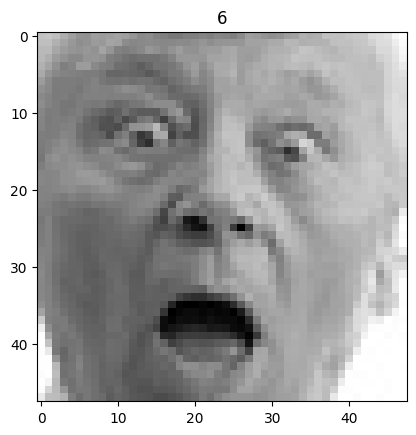

Compose(
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

In [6]:
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms
loc=28708
img=cv2.imread(train_df['File_Path'].loc[loc])
plt.imshow(img)
plt.title(train_df['Class Id'].loc[loc])
plt.show()
transform =transforms.Compose([transforms.Resize((128,128)),transforms.ToTensor()])
transform

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='File_Path',
    y_col='Class Name',
    subset='training',
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode='categorical',
    target_size=(224, 224),
    workers=7
)

Found 22968 validated image filenames belonging to 7 classes.


In [14]:
validation_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='File_Path',
    y_col='Class Name',
    subset='validation',
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode='categorical',
    target_size=(224, 224),
    workers=7
)

Found 5741 validated image filenames belonging to 7 classes.


In [15]:
print(train_generator.class_indices)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


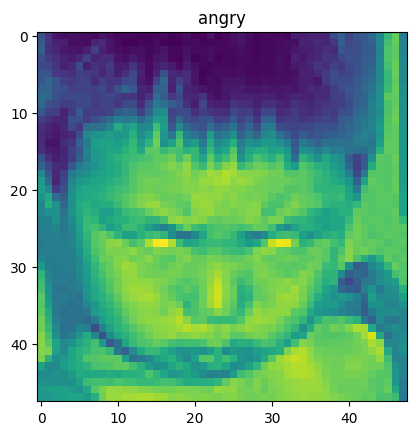

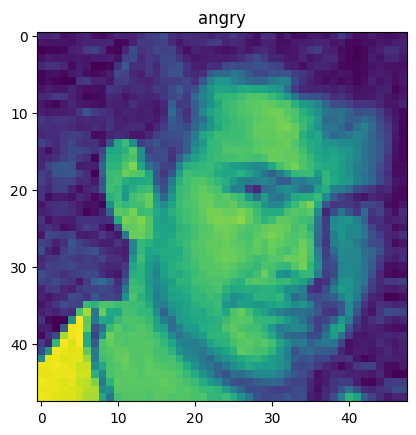

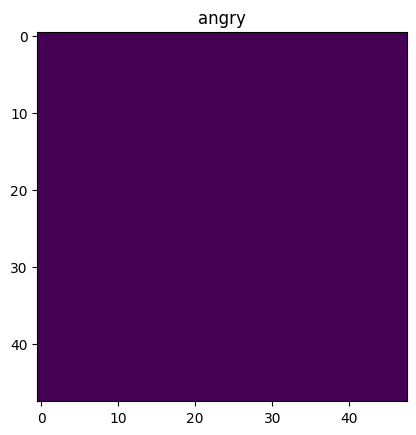

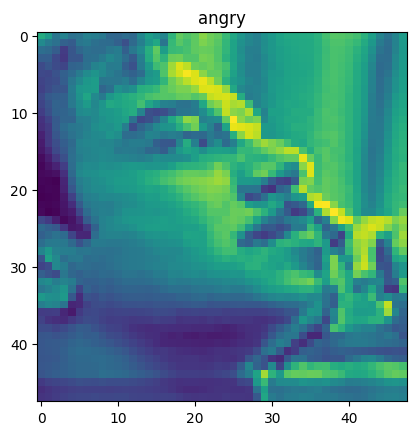

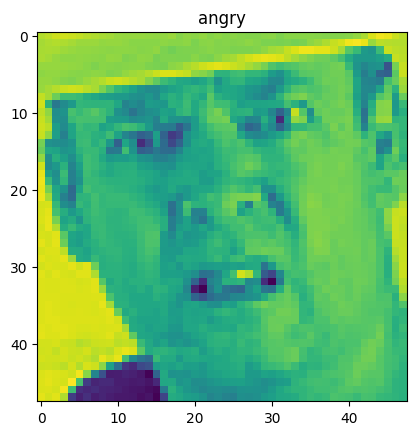

In [49]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for i in range(5):
    img_path = train_df.iloc[i]['File_Path']
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.title(train_df.iloc[i]['Class Name'])
    plt.show()

In [16]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
predictions

<KerasTensor shape=(None, 7), dtype=float32, sparse=False, name=keras_tensor_22>

In [39]:
import tensorflow as tf

if tf.config.list_physical_devices('GPU'):
    print("Yes")
else:
    print("No")

No


In [18]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, start_from_epoch=10)

In [19]:
#model.fit(train_generator, epochs=10, validation_data=validation_generator)
history = model.fit(train_generator, validation_data=validation_generator, epochs=30,callbacks=[early_stopping])

Epoch 1/30


c:\Users\Dharmarajan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


718/718 ━━━━━━━━━━━━━━━━━━━━ 3510s 5s/step


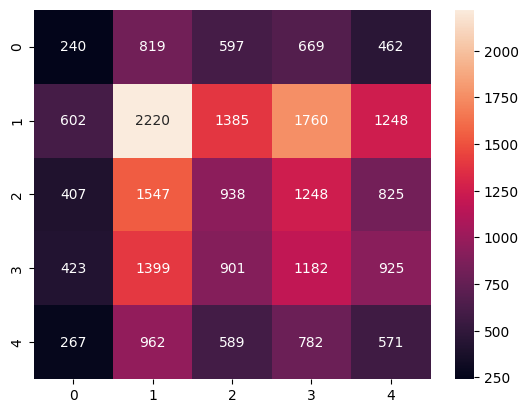

In [56]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

y_train_pred = model.predict(train_generator)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
y_train_true = train_generator.classes

cm_train = confusion_matrix(y_train_true, y_train_pred_classes)
sns.heatmap(cm_train, annot=True, fmt='d')
plt.show()

180/180 ━━━━━━━━━━━━━━━━━━━━ 901s 5s/step


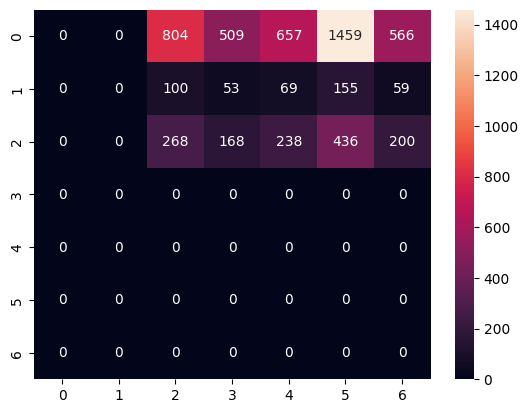

In [57]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

y_validate_pred = model.predict(validation_generator)
y_validate_pred_classes = np.argmax(y_validate_pred, axis=1)
y_validate_true = validation_generator.classes

cm_validate = confusion_matrix(y_validate_true, y_validate_pred_classes)
sns.heatmap(cm_validate, annot=True, fmt='d')
plt.show()

In [12]:
import pandas as pd
test_data = []

for index, cls_name in enumerate(os.listdir(test_path)):
    folder_path = os.path.join(test_path, cls_name)
    if os.path.isdir(folder_path):
        for root, _, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                test_data.append((index, cls_name, file_path))

# Convert the list to a DataFrame
test_df = pd.DataFrame(test_data, columns=['Class Id', 'Class Name', 'File_Path'])

# Print the resulting DataFrame
print(test_df)

      Class Id Class Name                                          File_Path
0            0      angry  C:/Users/Dharmarajan/Documents/Guvi/Project/Fi...
1            0      angry  C:/Users/Dharmarajan/Documents/Guvi/Project/Fi...
2            0      angry  C:/Users/Dharmarajan/Documents/Guvi/Project/Fi...
3            0      angry  C:/Users/Dharmarajan/Documents/Guvi/Project/Fi...
4            0      angry  C:/Users/Dharmarajan/Documents/Guvi/Project/Fi...
...        ...        ...                                                ...
7173         6   surprise  C:/Users/Dharmarajan/Documents/Guvi/Project/Fi...
7174         6   surprise  C:/Users/Dharmarajan/Documents/Guvi/Project/Fi...
7175         6   surprise  C:/Users/Dharmarajan/Documents/Guvi/Project/Fi...
7176         6   surprise  C:/Users/Dharmarajan/Documents/Guvi/Project/Fi...
7177         6   surprise  C:/Users/Dharmarajan/Documents/Guvi/Project/Fi...

[7178 rows x 3 columns]


In [14]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='File_Path',
    y_col='Class Name',
    batch_size=32,
    #seed=42,
    shuffle=True,
    class_mode='categorical',
    target_size=(128, 128)
)

Found 7178 validated image filenames belonging to 7 classes.


In [15]:
test_predict=model.predict(test_generator)
test_predict

c:\Users\Dharmarajan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


225/225 ━━━━━━━━━━━━━━━━━━━━ 3136s 14s/step


array([[0.14917602, 0.03530296, 0.13342611, ..., 0.16686912, 0.17169288,
        0.12899637],
       [0.1491356 , 0.03555199, 0.13348742, ..., 0.16680652, 0.17158917,
        0.12908377],
       [0.14917648, 0.03527703, 0.13343343, ..., 0.16687974, 0.1716898 ,
        0.12898561],
       ...,
       [0.1492306 , 0.03497462, 0.13334058, ..., 0.1669518 , 0.17183357,
        0.12887989],
       [0.14929868, 0.03457499, 0.13322523, ..., 0.16704921, 0.17201489,
        0.12873782],
       [0.14925385, 0.03483168, 0.13330504, ..., 0.1669887 , 0.17189285,
        0.12882839]], dtype=float32)

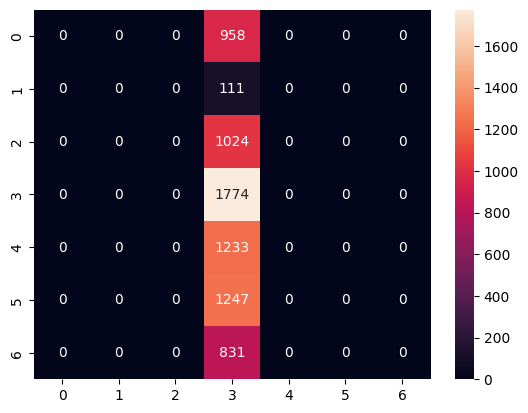

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#y_pred = model.predict(test_generator)
y_test_pred_classes = np.argmax(test_predict, axis=1)
y_test_true = test_generator.classes

cm_test = confusion_matrix(y_test_true, y_test_pred_classes)
sns.heatmap(cm_test, annot=True, fmt='d')
plt.show()

In [20]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load and preprocess the image
image_path = 'C:/Users/Dharmarajan/Downloads/PrivateTest_2642370.jpg'  # Replace with your image path
image = load_img(image_path, target_size=(128, 128))  # Resize the image to match your model's input size
image_array = img_to_array(image)  # Convert the image to a numpy array
image_array = image_array / 255.0  # Rescale the image

# If your model expects a batch of images, add an extra dimension
image_array = tf.expand_dims(image_array, axis=0)

# Now you can use this image_array as input to your model
predictions = model.predict(image_array)
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
[[0.14921233 0.03507559 0.13337226 0.21471174 0.16692777 0.17178498
  0.12891532]]


In [21]:
import numpy as np

# Assuming 'predictions' is your output array
predictions = np.array(predictions)

# Get the index of the highest value
predicted_class_index = np.argmax(predictions)

# If you have a list of class names, you can map the index to the class name
class_names = ['Angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']  # Replace with your actual class names
predicted_class = class_names[predicted_class_index]

print(f"The predicted class is: {predicted_class}")

The predicted class is: happy
